## Imports

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

from typing import List, Callable

In [45]:
# Loading pickled dataframe
PICKLE_PATH = "../data/apex"
df = pd.read_pickle(PICKLE_PATH)

In [46]:
# Setting seaborn figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})

Split the time series into a train and split part since we need a feature that we are predicting for. Unlike the typical random selection of train/test splits we can't do that with time series data. Hence we'll take a specific number of value from the beginning of the time series as the train split and the rest will be our test split.

In [47]:
TRAIN_SIZE = 1500

# Splitting the dataframe into train and test sets
df['train'] = df.players[:TRAIN_SIZE]
df['test'] = df.players[TRAIN_SIZE:]

Text(0.5, 1.0, 'Player Activity Train and Test Sets')

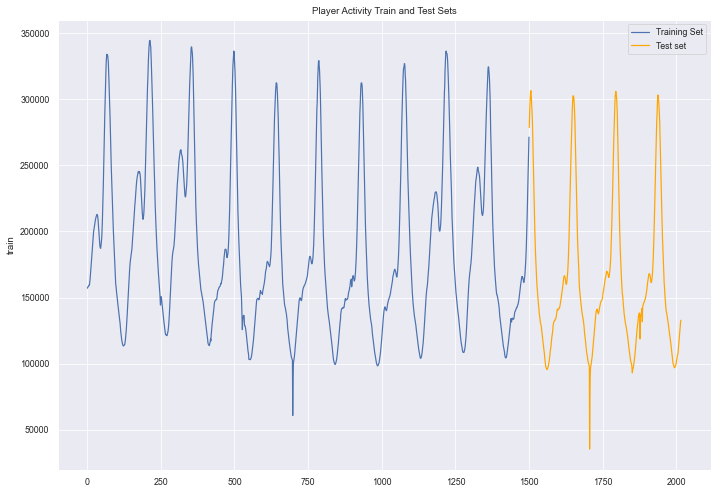

In [48]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")

fig.set_title("Player Activity Train and Test Sets")

When forecasting we will need a baseline to compare the performance of our model which we'll use y<sub>n+1</sub> = y<sub>n</sub> model as our naive base model.

In [49]:
# Predictions using the naive model
preds = np.repeat(df.train.dropna()[-1:], df.shape[0]-TRAIN_SIZE)

# All the predictions stored into the dataframe
#df['naive_pred'] = np.repeat(np.nan, TRAIN_SIZE) + preds
df['naive_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds
df

,date,players,twitch_viewers,date_interval,change_in_players,sma,std,day,hour,train,test,naive_pred
1,2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN,Fri,3,157067.0,NaN,NaN
2,2022-06-03 03:10:00,157714,69530,0 days 00:10:00,647,NaN,NaN,Fri,3,157714.0,NaN,NaN
3,2022-06-03 03:20:00,158014,69700,0 days 00:10:00,300,NaN,NaN,Fri,3,158014.0,NaN,NaN
4,2022-06-03 03:30:00,158552,72882,0 days 00:10:00,538,NaN,NaN,Fri,3,158552.0,NaN,NaN
5,2022-06-03 03:40:00,158599,70630,0 days 00:10:00,47,NaN,NaN,Fri,3,158599.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2022-06-17 02:10:00,123712,45020,0 days 00:10:00,3146,173694.795635,3.747205e+09,Fri,2,NaN,123712.0,271460.0
2013,2022-06-17 02:20:00,127175,44328,0 days 00:10:00,3463,173688.967262,3.747713e+09,Fri,2,NaN,127175.0,271460.0
2014,2022-06-17 02:30:00,129576,43811,0 days 00:10:00,2401,173682.773810,3.748221e+09,Fri,2,NaN,129576.0,271460.0
2015,2022-06-17 02:40:00,132040,44776,0 days 00:10:00,2464,173676.510913,3.748704e+09,Fri,2,NaN,132040.0,271460.0


In [50]:
# Computes the root mean square error
rmse = lambda actual, predicated: np.sqrt(mean_squared_error(actual, predicated))

# Computes the mean percentage error and root mean square error for naive model
naive_rmse = rmse(df.test[TRAIN_SIZE:], df.naive_pred[TRAIN_SIZE:]) 
naive_mape = mean_absolute_percentage_error(df.test[TRAIN_SIZE:], df.naive_pred[TRAIN_SIZE:])

The metric `root mean squared error` can be thought of as how wrong the prediction will be off by on average. Not surprisingly the RMSE is 124220 which means that the naive model is going to be off by a large amount.

We decide to use the `mean absolute percentage error` which we can think of as the analogous version of the accuracy metric for classification models. The naive model has a 89% mean absolute percentage error which is quite a lot. One can think of this as essentially having 11% accuracy. 

Text(0.5, 1.0, 'Player Activity Predictation: RMSE: 124220.72, MAPE: 0.89')

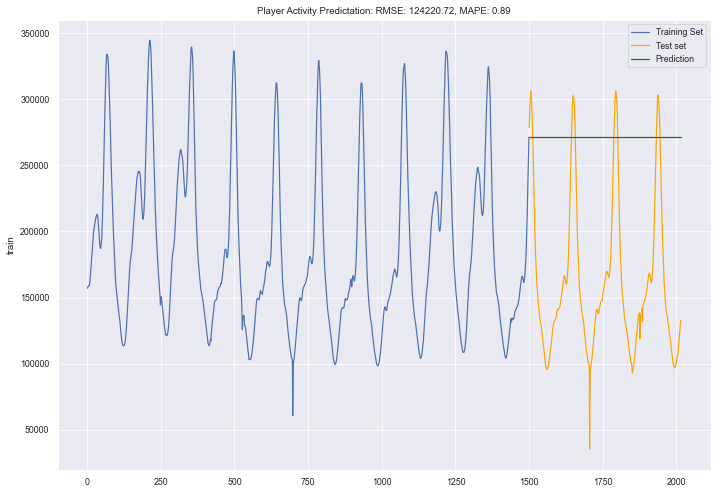

In [51]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")
sns.lineplot(data=df.naive_pred, color="green", label="Prediction")

fig.set_title(f"Player Activity Predictation: RMSE: {naive_rmse:.2f}, MAPE: {naive_mape:.2f}")

## Evaluating Model Performance

Implement `cross validation` for time series since we can not randomly choose samples and assign them for test or train sets due to our data being dependent on time. We use a handy function known as `TimeSeriesSplit` from sklearn to handle the splitting of our data.

In [62]:
def naive_model(train: pd.DataFrame, test: pd.DataFrame) -> List[any]:
    """ This is the baseline model to compare the performance of other models. It is a model that assumes
    that the next values of the time series will be whatever the previous value was. (y_n+1 = y_n) 

    Args:
        train (pd.DataFrame): The time series feature that we are interested in prediction.
        test (pd.DataFrame): The test data which we need just for the number of predictions.

    Returns:
        List[any]: Return the prediction as a list.
    """

    return np.repeat(train[-1:], test.shape[0])

In [ ]:
def eval_model_perf(df: pd.DataFrame , model: Callable[[pd.DataFrame, pd.DataFrame], List[any]]) -> None:
    """ Evaluates the performance of a model using RMSE and MAPE.

    Args:
        model (_type_): _description_
    """
    rmse_metrics = []
    mape_metrics = []

    tscv = TimeSeriesSplit(n_splits=4)

    for train_index, test_index in tscv.split(df):
        
        cv_train = df.iloc[train_index]
        cv_test = df.iloc[test_index]

        preds = model(cv_train, cv_test)

        rmse_eval = rmse(cv_test, preds) 
        naive_eval = mean_absolute_percentage_error(cv_test, preds)

        rmse_metrics.append(rmse_eval)
        mape_metrics.append(naive_eval)


    print("Cross Validation Results: ")
    print(f"RMSE: {np.mean(rmse_metrics)}")
    print(f"MAPE: {np.mean(mape_metrics)}")

    pass

In [64]:


rmse_metrics = []
mape_metrics = []

tscv = TimeSeriesSplit(n_splits=4)

for train_index, test_index in tscv.split(df.players):
    
    cv_train = df.players.iloc[train_index]
    cv_test = df.players.iloc[test_index]

    preds = naive_model(cv_train, cv_test)

    rmse_eval = rmse(cv_test, preds) 
    naive_eval = mean_absolute_percentage_error(cv_test, preds)

    rmse_metrics.append(rmse_eval)
    mape_metrics.append(naive_eval)


print("Cross Validation Results: ")
print(f"RMSE: {np.mean(rmse_metrics)}")
print(f"MAPE: {np.mean(mape_metrics)}")

    

Cross Validation Results: 
RMSE: 78484.76506417702
MAPE: 0.3972405577404642


In [53]:
# Moving Average

In [54]:
# LSTM